### Imports

In [1]:

import requests
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # Use gensim_models for LDA visualization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk import ngrams, FreqDist
from nltk.tokenize import word_tokenize
from bertopic import BERTopic

### Data Collection

In [ ]:

# Function to extract reviews from a single page
def scrape_reviews(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    # Make a request to the website
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to retrieve data from {url}")
        return []

    # Parse the page content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract review elements
    reviews = []
    
    # Target all review containers 
    review_containers = soup.select('article[class*="comp_media-review-rated list-item media position-content"]')

    if not review_containers:
        print(f"No reviews found on {url}")
        return reviews  # Return empty list if no reviews found
    
    for review in review_containers:
        # Extract individual data points from each review
        title = review.find('h2', class_='text_header').text.strip() if review.find('h2', class_='text_header') else None
        content = review.find('div', class_='text_content').text.strip() if review.find('div', class_='text_content') else None
        rating = review.find('span', itemprop='ratingValue').text.strip() if review.find('span', itemprop='ratingValue') else None
        date = review.find('time', itemprop='datePublished').text.strip() if review.find('time', itemprop='datePublished') else None
        
        # Extract the country
        country = None
        h3_tag = review.find('h3', class_='text_sub_header userStatusWrapper')
        if h3_tag and h3_tag.span and h3_tag.span.next_sibling:
            country = h3_tag.span.next_sibling.strip(" ()")
        
        # Extract other fields
        aircraft = review.find('td', class_="review-rating-header aircraft").find_next('td', class_="review-value").text.strip() if review.find('td', class_="review-rating-header aircraft") else None
        seat_type = review.find('td', class_="review-rating-header cabin_flown").find_next('td', class_="review-value").text.strip() if review.find('td', class_="review-rating-header cabin_flown") else None
        route = review.find('td', class_="review-rating-header route").find_next('td', class_="review-value").text.strip() if review.find('td', class_="review-rating-header route") else None
        date_flown = review.find('td', class_="review-rating-header date_flown").find_next('td', class_="review-value").text.strip() if review.find('td', class_="review-rating-header date_flown") else None
        traveller_type = review.find('td', class_="review-rating-header type_of_traveller").find_next('td', class_="review-value").text.strip() if review.find('td', class_="review-rating-header type_of_traveller") else None
        recommended = review.find('td', class_="review-rating-header recommended").find_next('td', class_="review-value").text.strip() if review.find('td', class_="review-rating-header recommended") else None

        # Extract ratings by category
        seat_comfort = extract_star_ratings(review, 'seat_comfort')
        cabin_staff_service = extract_star_ratings(review, 'cabin_staff_service')
        food_beverages = extract_star_ratings(review, 'food_and_beverages')
        inflight_entertainment = extract_star_ratings(review, 'inflight_entertainment')
        ground_service = extract_star_ratings(review, 'ground_service')
        wifi_connectivity = extract_star_ratings(review, 'wifi_and_connectivity')
        value_for_money = extract_star_ratings(review, 'value_for_money')

        # Append the review data as a dictionary
        reviews.append({
            'Title': title,
            'Content': content,
            'Rating': rating,
            'Date': date,
            'Country': country,
            'Aircraft': aircraft,
            'Seat Type': seat_type,
            'Route': route,
            'Date Flown': date_flown,
            'Traveller Type': traveller_type,
            'Recommended': recommended,
            'Seat Comfort': seat_comfort,
            'Cabin Staff Service': cabin_staff_service,
            'Food & Beverages': food_beverages,
            'Inflight Entertainment': inflight_entertainment,
            'Ground Service': ground_service,
            'Wifi & Connectivity': wifi_connectivity,
            'Value For Money': value_for_money
        })
    
    return reviews

# Function to scrape multiple pages
def scrape_multiple_pages(base_url, pages):
    all_reviews = []
    for page_num in range(1, pages+1):
        print(f"Scraping page {page_num}")
        url = f"{base_url}page/{page_num}/"
        reviews = scrape_reviews(url)
        if reviews:
            all_reviews.extend(reviews)
        else:
            print(f"No reviews found on page {page_num}")
        
        # Sleep to avoid overwhelming the server
        time.sleep(2)
    
    return all_reviews

def extract_star_ratings(review, category):
    # Find the row containing the category (e.g., Seat Comfort, Cabin Staff Service, etc.)
    rating_row = review.find('td', class_=f"review-rating-header {category}")
    
    if rating_row:
        # Find the stars in the next 'td' element
        stars = rating_row.find_next('td', class_='review-rating-stars stars').find_all('span', class_='star fill')
        return len(stars)  # Return the number of filled stars (e.g., 2 stars out of 5)
    return None

# URL of the review page
base_url = "https://www.airlinequality.com/airline-reviews/british-airways/"



In [ ]:
# Scrape multiple pages
reviews_data = scrape_multiple_pages(base_url, pages=387)

In [ ]:
# Convert the reviews data into a pandas DataFrame
df_reviews = pd.DataFrame(reviews_data)

# Save the DataFrame to a CSV file
df_reviews.to_csv('British_Airline_reviews.csv', index=False)

print("Reviews have been saved to 'airline_reviews.csv'.")

In [ ]:
df_reviews.head(10)

In [ ]:
df_reviews.info()

In [ ]:
df_reviews.describe()

### Data Cleaning

In [4]:
csv_file_path = '/Users/balajivijayaraj/Desktop/British_Airways/Task_1/British_Airline_reviews.csv'

# Load the CSV file into a pandas DataFrame
df_reviews = pd.read_csv(csv_file_path)


In [7]:
df_reviews.head(10)

,Title,Content,Rating,Date,Country,Aircraft,Seat Type,Route,Date Flown,Traveller Type,Recommended,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money
0,"""very disappointed""",Not Verified | My wife and I are very disappo...,1.0,13th September 2024,United States,NaN,Economy Class,Amsterdam to Pittsburgh via London,September 2024,Family Leisure,no,2.0,2.0,2.0,2.0,1.0,2.0,1
1,"""happily recommend and use BA""",Not Verified | We flew BA between Heathrow an...,8.0,13th September 2024,Australia,A321,Economy Class,Heathrow to Berlin,July 2024,Couple Leisure,yes,3.0,4.0,3.0,NaN,4.0,NaN,3
2,"""cannot get compensation for our flight""",Not Verified | Absolutely disgusted with BA. ...,1.0,13th September 2024,United Kingdom,NaN,Economy Class,Manchester to Seattle via London,May 2024,Couple Leisure,no,NaN,NaN,NaN,NaN,1.0,NaN,1
3,“Crew very friendly and attentive”,Not Verified | Took a trip to Nashville with m...,8.0,11th September 2024,United Kingdom,Boeing 777-2OOLR,Business Class,London Heathrow to Nashville,August 2024,Couple Leisure,yes,4.0,4.0,4.0,2.0,2.0,NaN,3
4,"""A nightmare journey""",Not Verified | A nightmare journey courtesy o...,1.0,8th September 2024,United Kingdom,A319 / A321NEO,Economy Class,London to Venice,September 2024,Couple Leisure,no,2.0,3.0,NaN,NaN,1.0,NaN,1
5,“One gets better service in McDonalds”,✅ Trip Verified | Absolutely atrocious. LHR-OR...,1.0,6th September 2024,United Kingdom,Boeing 777-300ER,First Class,London Heathrow to Chicago,August 2024,Business,no,1.0,1.0,1.0,1.0,1.0,1.0,1
6,"“shocking food, service, exorbitant prices”",✅ Trip Verified | As someone who flies relentl...,4.0,2nd September 2024,United Kingdom,NaN,Business Class,London to Crete,September 2024,Couple Leisure,no,2.0,1.0,1.0,1.0,2.0,3.0,2
7,"""delayed with no explanation""",✅ Trip Verified | Flew with British Airways ...,2.0,1st September 2024,United Kingdom,A319,Business Class,Berlin to London,August 2024,Business,no,3.0,1.0,3.0,NaN,1.0,NaN,1
8,"""Sound food and drink offered""",✅ Trip Verified | Straightforward check in T...,8.0,30th August 2024,United Kingdom,Boeing 777-200,Business Class,London to Toronto,August 2024,Family Leisure,yes,4.0,4.0,4.0,5.0,4.0,5.0,4
9,"“beyond appalled, hurt and frustrated”",Not Verified | I am beyond upset and disgusted...,1.0,28th August 2024,United Kingdom,NaN,Economy Class,London to Denver,August 2024,Solo Leisure,no,1.0,1.0,NaN,NaN,1.0,NaN,1


In [8]:

# Step 1: Handling Missing Values
# Check missing values in each column
missing_values = df_reviews.isnull().sum()
print("Missing values before cleaning:\n", missing_values)


Missing values before cleaning:
 Title                        0
Content                      0
Rating                       5
Date                         0
Country                      2
Aircraft                  1849
Seat Type                    2
Route                      776
Date Flown                 778
Traveller Type             771
Recommended                  0
Seat Comfort               125
Cabin Staff Service        139
Food & Beverages           425
Inflight Entertainment    1217
Ground Service             850
Wifi & Connectivity       3191
Value For Money              0
dtype: int64


In [9]:

# Handle missing values
# For categorical columns like 'Aircraft', 'Seat Type', etc., fill with 'Unknown'
df_reviews['Aircraft'] = df_reviews['Aircraft'].fillna('Unknown')
df_reviews['Seat Type'] = df_reviews['Seat Type'].fillna('Unknown')
df_reviews['Route'] = df_reviews['Route'].fillna('Unknown')
df_reviews['Traveller Type'] = df_reviews['Traveller Type'].fillna('Unknown')

In [10]:
missing_values = df_reviews.isnull().sum()
print("Missing values before cleaning:\n", missing_values)

Missing values before cleaning:
 Title                        0
Content                      0
Rating                       5
Date                         0
Country                      2
Aircraft                     0
Seat Type                    0
Route                        0
Date Flown                 778
Traveller Type               0
Recommended                  0
Seat Comfort               125
Cabin Staff Service        139
Food & Beverages           425
Inflight Entertainment    1217
Ground Service             850
Wifi & Connectivity       3191
Value For Money              0
dtype: int64


In [11]:
# Step 2: Handling Date columns
# Define a function to remove ordinal suffixes from the date strings
def remove_ordinal_suffixes(date_str):
    # Check if date_str is valid, since NaN or invalid strings might be present
    if pd.isna(date_str):
        return date_str
    return re.sub(r'(\d{1,2})(st|nd|rd|th)', r'\1', date_str)  # Remove ordinal suffixes like "1st", "2nd", "3rd", etc.

# Apply the function to remove ordinal suffixes from the 'Date' column
df_reviews['Date'] = df_reviews['Date'].astype(str).apply(remove_ordinal_suffixes)

# Parse the 'Date' column with the format 'Day Month Year'
df_reviews['Date'] = pd.to_datetime(df_reviews['Date'], format='%d %B %Y', errors='coerce')

In [12]:
# Verify the output and display the first few rows
print(df_reviews[['Date']].head())



        Date
0 2024-09-13
1 2024-09-13
2 2024-09-13
3 2024-09-11
4 2024-09-08


In [13]:
# Check for missing or invalid dates after the conversion
invalid_dates = df_reviews[df_reviews['Date'].isna()]
print("Rows with invalid 'Date':\n", invalid_dates[['Title', 'Content', 'Date']])

Rows with invalid 'Date':
 Empty DataFrame
Columns: [Title, Content, Date]
Index: []


In [15]:
# Parse the 'Date Flown' column with just Month and Year format
df_reviews['Date Flown'] = pd.to_datetime(df_reviews['Date Flown'], format='%B %Y', errors='coerce')

# Extract just the Month and Year from the parsed date
df_reviews['Date Flown'] = df_reviews['Date Flown'].dt.to_period('M')

In [16]:
print(df_reviews[['Date Flown']].head())


  Date Flown
0    2024-09
1    2024-07
2    2024-05
3    2024-08
4    2024-09


In [17]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861 entries, 0 to 3860
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Title                   3861 non-null   object        
 1   Content                 3861 non-null   object        
 2   Rating                  3856 non-null   float64       
 3   Date                    3861 non-null   datetime64[ns]
 4   Country                 3859 non-null   object        
 5   Aircraft                3861 non-null   object        
 6   Seat Type               3861 non-null   object        
 7   Route                   3861 non-null   object        
 8   Date Flown              3083 non-null   period[M]     
 9   Traveller Type          3861 non-null   object        
 10  Recommended             3861 non-null   object        
 11  Seat Comfort            3736 non-null   float64       
 12  Cabin Staff Service     3722 non-null   float64 

In [19]:
# Step 3: Removing Duplicate Entries

# Find rows that are completely identical across all columns
duplicate_reviews_all = df_reviews[df_reviews.duplicated(keep=False)]

# Display exact duplicate reviews
duplicate_reviews_all

,Title,Content,Rating,Date,Country,Aircraft,Seat Type,Route,Date Flown,Traveller Type,Recommended,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money
3129,British Airways customer review,BLQ-LGW and return. Operated by A319 clean tid...,8.0,2015-05-22,Italy,Unknown,Economy Class,Unknown,NaT,Unknown,yes,4.0,4.0,2.0,2.0,NaN,NaN,3
3133,British Airways customer review,BLQ-LGW and return. Operated by A319 clean tid...,8.0,2015-05-22,Italy,Unknown,Economy Class,Unknown,NaT,Unknown,yes,4.0,4.0,2.0,2.0,NaN,NaN,3
3134,British Airways customer review,Travelled from Heathrow to Washington in April...,10.0,2015-05-20,United Kingdom,Unknown,Economy Class,Unknown,NaT,Unknown,yes,5.0,5.0,4.0,5.0,NaN,NaN,4
3143,British Airways customer review,Travelled from Heathrow to Washington in April...,10.0,2015-05-20,United Kingdom,Unknown,Economy Class,Unknown,NaT,Unknown,yes,5.0,5.0,4.0,5.0,NaN,NaN,4
3208,British Airways customer review,LHR-FRA in Club Europe. First part is not real...,7.0,2015-04-14,United Kingdom,Unknown,Business Class,Unknown,NaT,Unknown,no,4.0,3.0,3.0,1.0,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3773,British Airways customer review,Travelling from Venice to London Gatwick with ...,1.0,2014-06-09,United Kingdom,Unknown,Economy Class,Unknown,NaT,Unknown,no,1.0,1.0,1.0,1.0,NaN,NaN,1
3848,British Airways customer review,Flew LHR - VIE return operated by bmi but BA a...,10.0,2012-08-29,United Kingdom,Unknown,Economy Class,Unknown,NaT,Unknown,yes,5.0,5.0,5.0,0.0,NaN,NaN,4
3849,British Airways customer review,Flight from Heathrow to Toronto. Booked emerge...,7.0,2012-08-29,United Kingdom,Unknown,Economy Class,Unknown,NaT,Unknown,no,3.0,3.0,3.0,4.0,NaN,NaN,3
3850,British Airways customer review,Flew LHR - VIE return operated by bmi but BA a...,10.0,2012-08-29,United Kingdom,Unknown,Economy Class,Unknown,NaT,Unknown,yes,5.0,5.0,5.0,0.0,NaN,NaN,4


In [20]:

# Find and remove rows that are completely identical across all columns, keeping only the first occurrence
df_reviews_cleaned = df_reviews.drop_duplicates(keep='first')

# Display the number of rows before and after removing duplicates
print(f"Number of rows before removing duplicates: {df_reviews.shape[0]}")
print(f"Number of rows after removing duplicates: {df_reviews_cleaned.shape[0]}")

Number of rows before removing duplicates: 3861
Number of rows after removing duplicates: 3806


In [21]:
# Step 4: Check for Outliers

# Define columns with valid ranges
valid_range_columns_1_to_5 = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 
                              'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity']

# Check for out-of-range values in the 'Rating' column (should be 0-10)
outliers_rating = df_reviews_cleaned[(df_reviews_cleaned['Rating'] < 0) | (df_reviews_cleaned['Rating'] > 10)]

# Check for out-of-range values in the columns with 0-5 scale
outliers_others = df_reviews_cleaned[(df_reviews_cleaned[valid_range_columns_1_to_5] < 0) | (df_reviews_cleaned[valid_range_columns_1_to_5] > 5)].dropna(how='all', subset=valid_range_columns_1_to_5)

# Display the outliers
print("Outliers in 'Rating' column (outside 0-10 range):\n", outliers_rating[['Title', 'Rating']])

print("\nOutliers in 0-5 scale columns:\n", outliers_others[['Title'] + valid_range_columns_1_to_5])


Outliers in 'Rating' column (outside 0-10 range):
 Empty DataFrame
Columns: [Title, Rating]
Index: []

Outliers in 0-5 scale columns:
 Empty DataFrame
Columns: [Title, Seat Comfort, Cabin Staff Service, Food & Beverages, Inflight Entertainment, Ground Service, Wifi & Connectivity]
Index: []


In [23]:

# Find rows where 'Rating' is missing (NaN)
missing_rating = df_reviews_cleaned[df_reviews_cleaned['Rating'].isna()]

# Display the missing 'Rating' rows
print("Rows with missing 'Rating':")
print(missing_rating[['Title', 'Content', 'Date', 'Rating']])


Rows with missing 'Rating':
                                Title  \
3285  British Airways customer review   
3415  British Airways customer review   
3432  British Airways customer review   
3666  British Airways customer review   
3702  British Airways customer review   

                                                Content       Date  Rating  
3285  Cabin crew polite unfortunately BA ran out of ... 2015-02-18     NaN  
3415  Phoenix to London - outbound a wonderful and e... 2014-12-10     NaN  
3432  On past experience I chose BA for our long hau... 2014-11-25     NaN  
3666  LHR-CPH-LHR Business Class. This is a joke. Sc... 2014-07-31     NaN  
3702  I flew with British Airways with my mother fro... 2014-07-15     NaN  


In [24]:
# Step 5: Standardizing Text Columns
# Convert 'Country' and 'Recommended' to lowercase for consistency
# Use .loc to safely modify the original DataFrame
df_reviews_cleaned.loc[:, 'Country'] = df_reviews_cleaned['Country'].str.lower()
df_reviews_cleaned.loc[:, 'Recommended'] = df_reviews_cleaned['Recommended'].str.lower()


In [25]:
# After cleaning, let's check the missing values again
missing_values_after = df_reviews_cleaned.isnull().sum()
print("Missing values after cleaning:\n", missing_values_after)

Missing values after cleaning:
 Title                        0
Content                      0
Rating                       5
Date                         0
Country                      2
Aircraft                     0
Seat Type                    0
Route                        0
Date Flown                 723
Traveller Type               0
Recommended                  0
Seat Comfort               125
Cabin Staff Service        139
Food & Beverages           425
Inflight Entertainment    1217
Ground Service             795
Wifi & Connectivity       3136
Value For Money              0
dtype: int64


In [26]:

# Save the cleaned dataset to a new CSV file
df_reviews_cleaned.to_csv('cleaned_airline_reviews.csv', index=False)
print("Cleaned data saved to 'cleaned_airline_reviews.csv'.")


Cleaned data saved to 'cleaned_airline_reviews.csv'.


In [27]:
print(df_reviews_cleaned[['Content']].head(10))


                                             Content
0  Not Verified |  My wife and I are very disappo...
1  Not Verified |  We flew BA between Heathrow an...
2  Not Verified |  Absolutely disgusted with BA. ...
3  Not Verified | Took a trip to Nashville with m...
4  Not Verified |  A nightmare journey courtesy o...
5  ✅ Trip Verified | Absolutely atrocious. LHR-OR...
6  ✅ Trip Verified | As someone who flies relentl...
7  ✅ Trip Verified |   Flew with British Airways ...
8  ✅ Trip Verified |   Straightforward check in T...
9  Not Verified | I am beyond upset and disgusted...


In [28]:
# Safely create a new column 'Trip Verified' using .loc to avoid SettingWithCopyWarning
df_reviews_cleaned.loc[:, 'Trip Verified'] = df_reviews_cleaned['Content'].apply(lambda x: True if '✅ Trip Verified' in x else False)

# Verify the new column
print(df_reviews_cleaned[['Content', 'Trip Verified']].head(10))


                                             Content  Trip Verified
0  Not Verified |  My wife and I are very disappo...          False
1  Not Verified |  We flew BA between Heathrow an...          False
2  Not Verified |  Absolutely disgusted with BA. ...          False
3  Not Verified | Took a trip to Nashville with m...          False
4  Not Verified |  A nightmare journey courtesy o...          False
5  ✅ Trip Verified | Absolutely atrocious. LHR-OR...           True
6  ✅ Trip Verified | As someone who flies relentl...           True
7  ✅ Trip Verified |   Flew with British Airways ...           True
8  ✅ Trip Verified |   Straightforward check in T...           True
9  Not Verified | I am beyond upset and disgusted...          False


In [29]:
# Save the cleaned DataFrame with the 'Trip Verified' column to a CSV file
df_reviews_cleaned.to_csv('cleaned_reviews_with_trip_verified.csv', index=False)

print("Data saved to 'cleaned_reviews_with_trip_verified.csv'.")


Data saved to 'cleaned_reviews_with_trip_verified.csv'.


In [30]:
cleaned_reviews_with_trip_verified = pd.read_csv('cleaned_reviews_with_trip_verified.csv')


In [31]:
# Display the first 5 rows of the 'Content' column
print(cleaned_reviews_with_trip_verified['Content'].head(10))


0    Not Verified |  My wife and I are very disappo...
1    Not Verified |  We flew BA between Heathrow an...
2    Not Verified |  Absolutely disgusted with BA. ...
3    Not Verified | Took a trip to Nashville with m...
4    Not Verified |  A nightmare journey courtesy o...
5    ✅ Trip Verified | Absolutely atrocious. LHR-OR...
6    ✅ Trip Verified | As someone who flies relentl...
7    ✅ Trip Verified |   Flew with British Airways ...
8    ✅ Trip Verified |   Straightforward check in T...
9    Not Verified | I am beyond upset and disgusted...
Name: Content, dtype: object


In [33]:
# Define a function to clean the "Trip Verified" and "Not Verified" from the content
def remove_verified_labels(text):
    # Use regex to remove any instance of "Trip Verified" and "Not Verified", accounting for variations
    text = re.sub(r'✅\s*Trip Verified\s*\|\s*', '', text)
    text = re.sub(r'Not Verified\s*\|\s*', '', text)
    return text

# Update the 'Content' column using .loc and apply the function
cleaned_reviews_with_trip_verified.loc[:, 'Content'] = cleaned_reviews_with_trip_verified['Content'].apply(remove_verified_labels)

# View the first 5 rows of the updated 'Content' column
print(cleaned_reviews_with_trip_verified['Content'].head())


0    My wife and I are very disappointed with flyin...
1    We flew BA between Heathrow and Berlin one way...
2    Absolutely disgusted with BA. Our flights were...
3    Took a trip to Nashville with my wife for a le...
4    A nightmare journey courtesy of British Airway...
Name: Content, dtype: object


In [34]:
print(cleaned_reviews_with_trip_verified['Content'].head(10))


0    My wife and I are very disappointed with flyin...
1    We flew BA between Heathrow and Berlin one way...
2    Absolutely disgusted with BA. Our flights were...
3    Took a trip to Nashville with my wife for a le...
4    A nightmare journey courtesy of British Airway...
5    Absolutely atrocious. LHR-ORD-LHR Round-trip. ...
6    As someone who flies relentlessly with British...
7    Flew with British Airways club Europe on Satur...
8    Straightforward check in T5. New site for club...
9    I am beyond upset and disgusted with the disre...
Name: Content, dtype: object


In [35]:
print(cleaned_reviews_with_trip_verified['Title'].head(10))


0                            "very disappointed"
1                 "happily recommend and use BA"
2       "cannot get compensation for our flight"
3             “Crew very friendly and attentive”
4                          "A nightmare journey"
5         “One gets better service in McDonalds”
6    “shocking food, service, exorbitant prices”
7                  "delayed with no explanation"
8                 "Sound food and drink offered"
9         “beyond appalled, hurt and frustrated”
Name: Title, dtype: object


In [36]:
# Remove both single and double quotation marks from the 'Title' column
cleaned_reviews_with_trip_verified['Title'] = cleaned_reviews_with_trip_verified['Title'].str.replace(r'[\'"“”]', '', regex=True)

# Display the first 10 rows of the 'Title' column to confirm changes
print(cleaned_reviews_with_trip_verified['Title'].head(10))


0                            very disappointed
1                 happily recommend and use BA
2       cannot get compensation for our flight
3             Crew very friendly and attentive
4                          A nightmare journey
5         One gets better service in McDonalds
6    shocking food, service, exorbitant prices
7                  delayed with no explanation
8                 Sound food and drink offered
9         beyond appalled, hurt and frustrated
Name: Title, dtype: object


In [37]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/balajivijayaraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:

# Download NLTK resources (stopwords and wordnet for lemmatization)
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean the text and lemmatize
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove stopwords and lemmatize words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    
    return text




[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/balajivijayaraj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
# Update the 'Cleaned_Content' column using .loc
cleaned_reviews_with_trip_verified.loc[:, 'Cleaned_Content'] = cleaned_reviews_with_trip_verified['Content'].apply(clean_text)

# View the first few rows of the updated DataFrame
print(cleaned_reviews_with_trip_verified[['Content', 'Cleaned_Content']].head())


                                             Content  \
0  My wife and I are very disappointed with flyin...   
1  We flew BA between Heathrow and Berlin one way...   
2  Absolutely disgusted with BA. Our flights were...   
3  Took a trip to Nashville with my wife for a le...   
4  A nightmare journey courtesy of British Airway...   

                                     Cleaned_Content  
0  wife disappointed flying british airway flight...  
1  flew ba heathrow berlin one way connection exp...  
2  absolutely disgusted ba flight cancelled may b...  
3  took trip nashville wife leisure break arrived...  
4  nightmare journey courtesy british airway wors...  


In [40]:
# Update the 'Cleaned_Title' column using .loc
cleaned_reviews_with_trip_verified.loc[:, 'Cleaned_Title'] = cleaned_reviews_with_trip_verified['Title'].apply(clean_text)

# View the first few rows of the updated DataFrame
print(cleaned_reviews_with_trip_verified[['Title', 'Cleaned_Title']].head())


                                    Title                   Cleaned_Title
0                       very disappointed                    disappointed
1            happily recommend and use BA        happily recommend use ba
2  cannot get compensation for our flight  cannot get compensation flight
3        Crew very friendly and attentive         crew friendly attentive
4                     A nightmare journey               nightmare journey


In [41]:
# Write the DataFrame to a CSV file
cleaned_reviews_with_trip_verified.to_csv('cleaned_reviews_with_text_prepared.csv', index=False)

print("DataFrame written to CSV successfully!")


DataFrame written to CSV successfully!


### Code for sentiment analysis

In [42]:
# Load the DataFrame from the CSV file
cleaned_reviews_with_text_prepared = pd.read_csv('cleaned_reviews_with_text_prepared.csv')

# Display the first few rows to confirm loading
print(cleaned_reviews_with_text_prepared.head())


                                    Title  \
0                       very disappointed   
1            happily recommend and use BA   
2  cannot get compensation for our flight   
3        Crew very friendly and attentive   
4                     A nightmare journey   

                                             Content  Rating        Date  \
0  My wife and I are very disappointed with flyin...     1.0  2024-09-13   
1  We flew BA between Heathrow and Berlin one way...     8.0  2024-09-13   
2  Absolutely disgusted with BA. Our flights were...     1.0  2024-09-13   
3  Took a trip to Nashville with my wife for a le...     8.0  2024-09-11   
4  A nightmare journey courtesy of British Airway...     1.0  2024-09-08   

          Country          Aircraft       Seat Type  \
0   united states           Unknown   Economy Class   
1       australia              A321   Economy Class   
2  united kingdom           Unknown   Economy Class   
3  united kingdom  Boeing 777-2OOLR  Business Class 

In [43]:

# Function to calculate sentiment polarity using TextBlob
def get_sentiment_textblob(review):
    analysis = TextBlob(review)
    # Polarity ranges from -1 (negative) to 1 (positive)
    return analysis.sentiment.polarity

# Apply the sentiment analysis to the 'Content' column
cleaned_reviews_with_text_prepared['Sentiment_TextBlob'] = cleaned_reviews_with_text_prepared['Cleaned_Content'].apply(get_sentiment_textblob)

# Preview the new column
print(cleaned_reviews_with_text_prepared[['Cleaned_Content', 'Sentiment_TextBlob']].head())


                                     Cleaned_Content  Sentiment_TextBlob
0  wife disappointed flying british airway flight...           -0.262500
1  flew ba heathrow berlin one way connection exp...            0.176705
2  absolutely disgusted ba flight cancelled may b...           -0.381250
3  took trip nashville wife leisure break arrived...            0.085826
4  nightmare journey courtesy british airway wors...           -0.200000


In [44]:

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity using VADER
def get_sentiment_vader(review):
    sentiment = sia.polarity_scores(review)
    # Return the compound score which is a normalized value between -1 (negative) and 1 (positive)
    return sentiment['compound']

# Apply VADER sentiment analysis to the 'Content' column
cleaned_reviews_with_text_prepared['Sentiment_VADER'] = cleaned_reviews_with_text_prepared['Cleaned_Content'].apply(get_sentiment_vader)

# Preview the new column
print(cleaned_reviews_with_text_prepared[['Cleaned_Content', 'Sentiment_VADER']].head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/balajivijayaraj/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                     Cleaned_Content  Sentiment_VADER
0  wife disappointed flying british airway flight...          -0.7964
1  flew ba heathrow berlin one way connection exp...           0.9856
2  absolutely disgusted ba flight cancelled may b...          -0.8268
3  took trip nashville wife leisure break arrived...           0.8655
4  nightmare journey courtesy british airway wors...          -0.6677


In [45]:
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

cleaned_reviews_with_text_prepared['Sentiment_Category_VADER'] = cleaned_reviews_with_text_prepared['Sentiment_VADER'].apply(categorize_sentiment)

# Preview the sentiment categories
print(cleaned_reviews_with_text_prepared[['Cleaned_Content', 'Sentiment_VADER', 'Sentiment_Category_VADER']].head())


                                     Cleaned_Content  Sentiment_VADER  \
0  wife disappointed flying british airway flight...          -0.7964   
1  flew ba heathrow berlin one way connection exp...           0.9856   
2  absolutely disgusted ba flight cancelled may b...          -0.8268   
3  took trip nashville wife leisure break arrived...           0.8655   
4  nightmare journey courtesy british airway wors...          -0.6677   

  Sentiment_Category_VADER  
0                 Negative  
1                 Positive  
2                 Negative  
3                 Positive  
4                 Negative  


In [46]:
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

cleaned_reviews_with_text_prepared['Sentiment_Category_TextBlob'] = cleaned_reviews_with_text_prepared['Sentiment_TextBlob'].apply(categorize_sentiment)

# Preview the sentiment categories
print(cleaned_reviews_with_text_prepared[['Cleaned_Content', 'Sentiment_TextBlob', 'Sentiment_Category_TextBlob']].head())


                                     Cleaned_Content  Sentiment_TextBlob  \
0  wife disappointed flying british airway flight...           -0.262500   
1  flew ba heathrow berlin one way connection exp...            0.176705   
2  absolutely disgusted ba flight cancelled may b...           -0.381250   
3  took trip nashville wife leisure break arrived...            0.085826   
4  nightmare journey courtesy british airway wors...           -0.200000   

  Sentiment_Category_TextBlob  
0                    Negative  
1                    Positive  
2                    Negative  
3                    Positive  
4                    Negative  


In [47]:
# Write the DataFrame to a CSV file
cleaned_reviews_with_text_prepared.to_csv('cleaned_reviews_with_sentiment_score.csv', index=False)

print("DataFrame written to CSV successfully!")


DataFrame written to CSV successfully!


### Code for Topic Modelling

In [48]:
# Load the DataFrame from the CSV file
cleaned_reviews_with_sentiment_score = pd.read_csv('cleaned_reviews_with_sentiment_score.csv')

In [49]:
cleaned_reviews_with_sentiment_score.head(10)

,Title,Content,Rating,Date,Country,Aircraft,Seat Type,Route,Date Flown,Traveller Type,...,Ground Service,Wifi & Connectivity,Value For Money,Trip Verified,Cleaned_Content,Cleaned_Title,Sentiment_TextBlob,Sentiment_VADER,Sentiment_Category_VADER,Sentiment_Category_TextBlob
0,very disappointed,My wife and I are very disappointed with flyin...,1.0,2024-09-13,united states,Unknown,Economy Class,Amsterdam to Pittsburgh via London,2024-09,Family Leisure,...,1.0,2.0,1,False,wife disappointed flying british airway flight...,disappointed,-0.262500,-0.7964,Negative,Negative
1,happily recommend and use BA,We flew BA between Heathrow and Berlin one way...,8.0,2024-09-13,australia,A321,Economy Class,Heathrow to Berlin,2024-07,Couple Leisure,...,4.0,NaN,3,False,flew ba heathrow berlin one way connection exp...,happily recommend use ba,0.176705,0.9856,Positive,Positive
2,cannot get compensation for our flight,Absolutely disgusted with BA. Our flights were...,1.0,2024-09-13,united kingdom,Unknown,Economy Class,Manchester to Seattle via London,2024-05,Couple Leisure,...,1.0,NaN,1,False,absolutely disgusted ba flight cancelled may b...,cannot get compensation flight,-0.381250,-0.8268,Negative,Negative
3,Crew very friendly and attentive,Took a trip to Nashville with my wife for a le...,8.0,2024-09-11,united kingdom,Boeing 777-2OOLR,Business Class,London Heathrow to Nashville,2024-08,Couple Leisure,...,2.0,NaN,3,False,took trip nashville wife leisure break arrived...,crew friendly attentive,0.085826,0.8655,Positive,Positive
4,A nightmare journey,A nightmare journey courtesy of British Airway...,1.0,2024-09-08,united kingdom,A319 / A321NEO,Economy Class,London to Venice,2024-09,Couple Leisure,...,1.0,NaN,1,False,nightmare journey courtesy british airway wors...,nightmare journey,-0.200000,-0.6677,Negative,Negative
5,One gets better service in McDonalds,Absolutely atrocious. LHR-ORD-LHR Round-trip. ...,1.0,2024-09-06,united kingdom,Boeing 777-300ER,First Class,London Heathrow to Chicago,2024-08,Business,...,1.0,1.0,1,True,absolutely atrocious lhrordlhr roundtrip briti...,one get better service mcdonalds,-0.069176,-0.9583,Negative,Negative
6,"shocking food, service, exorbitant prices",As someone who flies relentlessly with British...,4.0,2024-09-02,united kingdom,Unknown,Business Class,London to Crete,2024-09,Couple Leisure,...,2.0,3.0,2,True,someone fly relentlessly british airway busine...,shocking food service exorbitant price,-0.005556,0.7269,Positive,Negative
7,delayed with no explanation,Flew with British Airways club Europe on Satur...,2.0,2024-09-01,united kingdom,A319,Business Class,Berlin to London,2024-08,Business,...,1.0,NaN,1,True,flew british airway club europe saturday st au...,delayed explanation,-0.113095,-0.8225,Negative,Negative
8,Sound food and drink offered,Straightforward check in T5. New site for club...,8.0,2024-08-30,united kingdom,Boeing 777-200,Business Class,London to Toronto,2024-08,Family Leisure,...,4.0,5.0,4,True,straightforward check new site club check work...,sound food drink offered,0.253725,0.8176,Positive,Positive
9,"beyond appalled, hurt and frustrated",I am beyond upset and disgusted with the disre...,1.0,2024-08-28,united kingdom,Unknown,Economy Class,London to Denver,2024-08,Solo Leisure,...,1.0,NaN,1,False,beyond upset disgusted disregard lack knowledg...,beyond appalled hurt frustrated,-0.041477,-0.9904,Negative,Negative


In [53]:
# Let's use the 'Cleaned_Content' column for topic modeling
M_cleaned_documents = cleaned_reviews_with_sentiment_score['Cleaned_Content'].tolist()

# Initialize BERTopic model
M_cleaned_content_topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2")

# Fit the model to the documents (customer reviews)
topics, probs = M_cleaned_content_topic_model.fit_transform(M_cleaned_documents)

# Display the found topics
M_cleaned_content_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1972,-1_seat_flight_ba_crew,"[seat, flight, ba, crew, cabin, food, service,...",[verified review heathrow hong kong business c...
1,0,747,0_flight_ba_hour_customer,"[flight, ba, hour, customer, day, told, britis...",[terrible experience british airway booked fli...
2,1,97,1_ba_seat_business_class,"[ba, seat, business, class, airline, flight, y...",[silver card holder work aviation fly around t...
3,2,82,2_good_heathrow_london_flight,"[good, heathrow, london, flight, food, excelle...",[flew british airway prague new york via londo...
4,3,75,3_gatwick_flight_lounge_club,"[gatwick, flight, lounge, club, food, cabin, c...",[paphos london gatwick club europe checked lea...
5,4,67,4_food_airway_british_meal,"[food, airway, british, meal, chicken, flight,...",[earth happened british airway inflight meal w...
6,5,61,5_heathrow_airline_verified_review,"[heathrow, airline, verified, review, london, ...",[verified review flew london heathrow vienna w...
7,6,59,6_class_business_airway_seat,"[class, business, airway, seat, british, first...",[booked british airway trip sydney london via ...
8,7,57,7_seat_club_world_deck,"[seat, club, world, deck, good, comfortable, u...",[recently flew ba lhr ord upper deck club worl...
9,8,56,8_bangkok_meal_british_airway,"[bangkok, meal, british, airway, seat, screen,...",[london bangkok flew british airway first time...


In [54]:
# Get topic information from the BERTopic model
topic_info = M_cleaned_content_topic_model.get_topic_info()

# Convert the topic information into a DataFrame
df_topics = pd.DataFrame(topic_info)

df_topics

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1972,-1_seat_flight_ba_crew,"[seat, flight, ba, crew, cabin, food, service,...",[verified review heathrow hong kong business c...
1,0,747,0_flight_ba_hour_customer,"[flight, ba, hour, customer, day, told, britis...",[terrible experience british airway booked fli...
2,1,97,1_ba_seat_business_class,"[ba, seat, business, class, airline, flight, y...",[silver card holder work aviation fly around t...
3,2,82,2_good_heathrow_london_flight,"[good, heathrow, london, flight, food, excelle...",[flew british airway prague new york via londo...
4,3,75,3_gatwick_flight_lounge_club,"[gatwick, flight, lounge, club, food, cabin, c...",[paphos london gatwick club europe checked lea...
5,4,67,4_food_airway_british_meal,"[food, airway, british, meal, chicken, flight,...",[earth happened british airway inflight meal w...
6,5,61,5_heathrow_airline_verified_review,"[heathrow, airline, verified, review, london, ...",[verified review flew london heathrow vienna w...
7,6,59,6_class_business_airway_seat,"[class, business, airway, seat, british, first...",[booked british airway trip sydney london via ...
8,7,57,7_seat_club_world_deck,"[seat, club, world, deck, good, comfortable, u...",[recently flew ba lhr ord upper deck club worl...
9,8,56,8_bangkok_meal_british_airway,"[bangkok, meal, british, airway, seat, screen,...",[london bangkok flew british airway first time...


In [55]:
# Extract only the 'Topic' and 'Name' columns (representations)
df_topics_representations = topic_info[['Topic', 'Name']]

df_topics_representations

,Topic,Name
0,-1,-1_seat_flight_ba_crew
1,0,0_flight_ba_hour_customer
2,1,1_ba_seat_business_class
3,2,2_good_heathrow_london_flight
4,3,3_gatwick_flight_lounge_club
5,4,4_food_airway_british_meal
6,5,5_heathrow_airline_verified_review
7,6,6_class_business_airway_seat
8,7,7_seat_club_world_deck
9,8,8_bangkok_meal_british_airway


In [56]:
M_cleaned_content_topic_model.visualize_topics()


In [57]:
M_cleaned_content_topic_model.visualize_barchart()

### Inferences:

1. **Improvement Opportunities:**
   - **Refund and Customer Service**: Topics related to **refunds** and **customer service** highlight dissatisfaction in these areas. British Airways could focus on improving its refund policies and enhancing customer support efficiency to reduce negative feedback.
   - **Seating and Comfort**: Several topics discuss **seating**, especially in business class, as well as comfort-related aspects like legroom and entertainment. Improvements in seat comfort and inflight amenities could significantly boost passenger satisfaction.
   - **Delays**: Multiple topics discuss delays. Addressing punctuality issues, especially on specific routes (like **Amsterdam**, **JFK**, etc.), could improve customer perceptions.

2. **Positive Aspects to Leverage**:
   - **Crew Service**: Positive reviews about the crew indicate that British Airways could leverage its strong cabin crew service as a competitive advantage, emphasizing this in marketing and service strategies.
   - **Lounges**: The frequent discussion of **lounge experiences**, particularly in Gatwick and business class, suggests that British Airways’ premium lounge services are widely discussed. Further enhancement or consistent service across lounges could help maintain or improve customer satisfaction.

3. **Specific Routes and Airports**:
   - There are several route-specific mentions, which might indicate either common issues or experiences related to these routes. British Airways could investigate if particular routes (e.g., **Bangkok**, **JFK**, **Sydney**, **St. Lucia**) are receiving disproportionately negative or positive reviews and address route-specific issues accordingly.

### Conclusion:
The topic modeling results give British Airways actionable insights into various facets of their service, including areas of improvement (refunds, seating, delays) and areas of strength (crew service, lounges). By addressing recurring complaints and promoting their strong points, British Airways can improve overall customer satisfaction and optimize key parts of their customer experience.


### Code for wordcloud

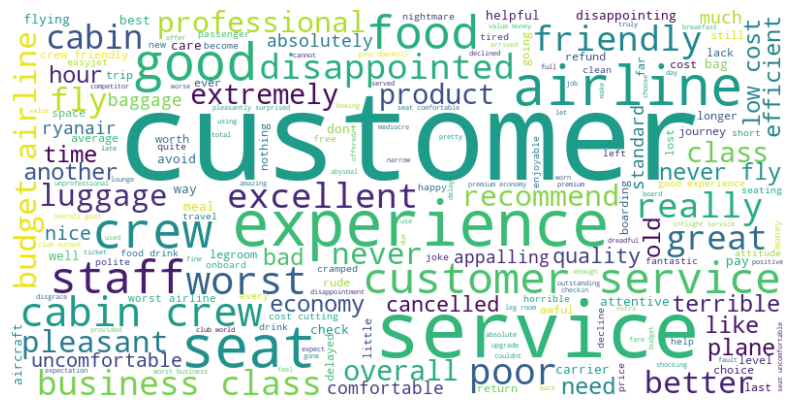

In [58]:
# Define your custom stop words
stop_words = set(['flight', 'ba', 'british', 'airways', 'airway', 'could', 'ife', 'go',  'gave', 'say',  'would', 'one', 'get', 'first', 'u', 'verified', 'review', 'also', 'however', 'got'])

# Combine all the text from the 'Cleaned_Content' column into a single string
all_text = ' '.join(cleaned_reviews_with_sentiment_score['Cleaned_Title'].dropna())

# Generate the word cloud, excluding the stop words
wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(all_text)

# Display the generated word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for word cloud
#plt.title('Word Cloud of Title')
plt.show()

### Key Observations:

- **Customer Service**: Frequent mentions of **"customer"** and **"service"** suggest that customer experience is a major focus. Both positive and negative sentiments exist, indicating inconsistencies in service quality.
  
- **Seat and Cabin Comfort**: Words like **"seat"** and **"cabin"** indicate that seating comfort is a common point of discussion. Improving seat comfort, especially in economy class, could enhance satisfaction.

- **Staff and Crew**: Positive mentions of **"friendly"** and **"professional"** suggest that many passengers appreciate the crew. However, negative terms indicate inconsistent service.

- **Business Class**: The frequent appearance of **"business class"** suggests this is a high-importance segment. Ensuring excellent service for premium passengers is key.

- **Food and Beverage**: The prominence of **"food"** indicates that inflight catering is a widely discussed topic. Improving food quality could enhance passenger satisfaction.

- **Baggage Handling**: Words like **"luggage"** and **"baggage"** suggest this is a recurring issue. Improving the baggage handling process could reduce complaints.

- **Delays**: Mentions of **"hour"** suggest concerns about flight delays and timeliness. Addressing operational inefficiencies could improve customer experience.

### Conclusion:
Improving seat comfort, customer service consistency, inflight catering, baggage handling, and timeliness are key areas British Airways should focus on to boost overall passenger satisfaction.


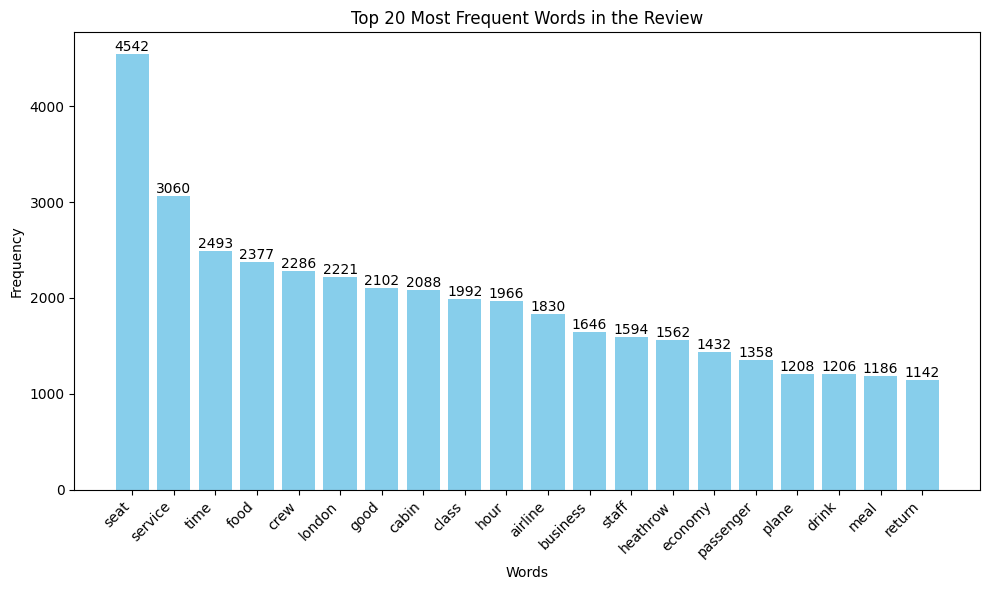

In [59]:

# Define a list of words to remove
stop_words = set(['flight', 'ba', 'british', 'airways', 'airway', 'could', 'ife', 'go',  'gave', 'say',  'would', 'one', 'get', 'first', 'u', 'verified', 'review', 'also', 'however', 'got'])

# Combine all the text from the 'Cleaned_Content' column into a single string
all_text = ' '.join(cleaned_reviews_with_sentiment_score['Cleaned_Content'].dropna())

# Split the text into individual words (tokenize)
words = all_text.split()

# Remove specific words from the list
filtered_words = [word for word in words if word not in stop_words]

# Count the frequency of each word
word_counts = Counter(filtered_words)

# Create a DataFrame for the top N most common words (e.g., top 20 words)
top_n_words = 20
word_freq_df = pd.DataFrame(word_counts.most_common(top_n_words), columns=['Word', 'Frequency'])

# Plot a bar chart for the most frequent words
plt.figure(figsize=(10, 6))
bars = plt.bar(word_freq_df['Word'], word_freq_df['Frequency'], color='skyblue')

# Add word frequency labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n_words} Most Frequent Words in the Review')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


### Code for N-gram

In [60]:
# Download NLTK data if necessary
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/balajivijayaraj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[(('world', 'traveller', 'plus', 'premium'), 10), (('traveller', 'plus', 'premium', 'economy'), 9), (('cabin', 'crew', 'friendly', 'attentive'), 8), (('first', 'time', 'flying', 'ba'), 7), (('captain', 'kept', 'us', 'informed'), 7), (('business', 'class', 'club', 'world'), 7), (('club', 'europe', 'business', 'class'), 7), (('los', 'angeles', 'via', 'london'), 6), (('flown', 'ba', 'many', 'years'), 6), (('short', 'haul', 'business', 'class'), 6), (('cabin', 'crew', 'efficient', 'friendly'), 6), (('business', 'class', 'premium', 'economy'), 5), (('worst', 'business', 'class', 'experience'), 5), (('customer', 'service', 'non', 'existent'), 5), (('cabin', 'crew', 'friendly', 'efficient'), 5), (('person', 'front', 'reclined', 'seat'), 5), (('club', 'world', 'business', 'class'), 5), (('worst', 'customer', 'service', 'ever'), 5), (('seats', 'middle', 'seat', 'blocked'), 5), (('rio', 'de', 'janeiro', 'london'), 5), (('london', 'sydney', 'via', 'singapore'), 5), (('san', 'francisco', 'via', 'l

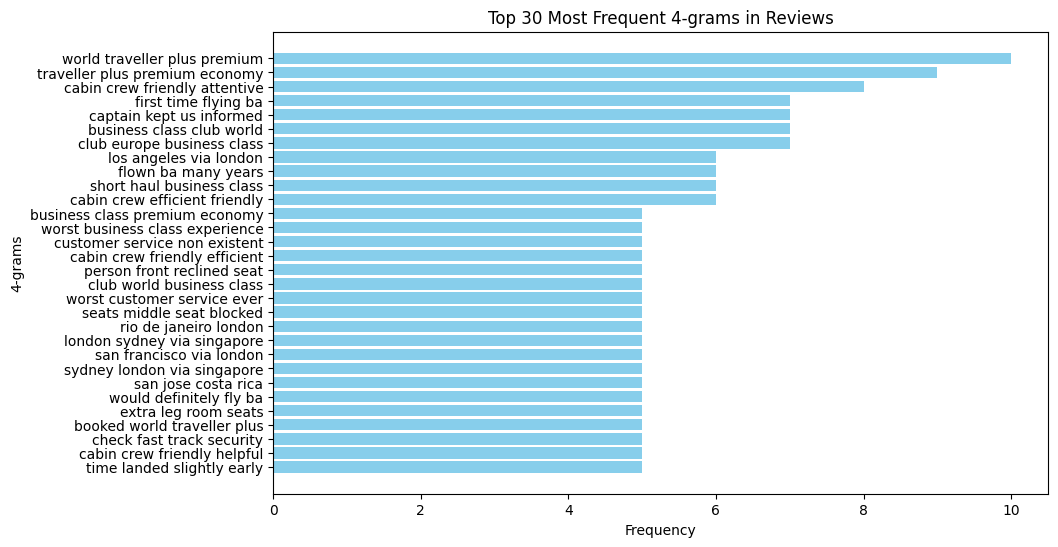

In [61]:

# Create a set of stop words (general stop words + custom stop words)
stop_words = set(stopwords.words('english'))  # General English stop words
custom_stop_words = {'verified', 'review', 'british', 'airways', 'airway', 'flight', 'lomdon', 'heathrow', 'new', 'york'}  # Custom stop words
stop_words.update(custom_stop_words)

# Function to clean text, remove stop words, and tokenize
def clean_and_tokenize(text):
    # Convert to lowercase and remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text.lower())
    
    # Tokenize the text into words, with correct language parameter and preserve_line
    words = word_tokenize(text, language='english', preserve_line=True)
    
    # Remove stop words (both general and custom)
    words = [word for word in words if word not in stop_words]
    
    return words

# Apply the clean_and_tokenize function to the 'Content' column
all_words = []
for text in cleaned_reviews_with_sentiment_score['Content'].dropna():
    all_words.extend(clean_and_tokenize(text))

# Generate 4-grams from the tokenized words
n = 4 
four_grams = list(ngrams(all_words, n))

# Calculate the frequency distribution of the 4-grams
fdist = FreqDist(four_grams)

# Display the top 10 most common 4-grams
top_n = 30
print(fdist.most_common(top_n))

# Plot the frequency distribution of the top 10 4-grams
four_grams, freq = zip(*fdist.most_common(top_n))
four_grams_str = [' '.join(gram) for gram in four_grams]  # Convert tuple of words to strings

plt.figure(figsize=(10, 6))
plt.barh(four_grams_str, freq, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('4-grams')
plt.title(f'Top {top_n} Most Frequent 4-grams in Reviews')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


### Observations from the 4-Gram Analysis:

1. **Frequent Mentions of Premium and Business Class**:
   - Phrases like **"world traveller plus premium"**, **"traveller plus premium economy"**, and **"business class club world"** show that customers frequently mention premium and business class experiences. This suggests that these travel classes are of significant interest to passengers and could imply both positive and negative feedback about these services.

2. **Cabin Crew and Customer Service**:
   - Phrases such as **"cabin crew friendly attentive"**, **"cabin crew efficient friendly"**, and **"customer service non existent"** indicate that customer service, especially related to the cabin crew, is a recurring theme. While some customers highlight positive interactions, others mention negative experiences, such as nonexistent or poor service.
   
3. **Flight Experience and Delays**:
   - The phrases **"person front reclined seat"**, **"seats middle seat blocked"**, and **"time landed slightly early"** suggest that aspects of the physical flight experience, including seat comfort and landing times, are frequently discussed. The mention of blocked middle seats might be associated with flight comfort, while mentions of early or delayed landings highlight timeliness concerns.
   
4. **Route-Specific Feedback**:
   - Certain routes like **"los angeles via london"**, **"rio de janeiro london"**, **"london sydney via singapore"**, and **"san francisco via london"** are frequently mentioned, which could point to specific issues or praise related to these long-haul flights. British Airways might want to analyze these specific routes for recurring feedback.

5. **Customer Satisfaction**:
   - The presence of both **"worst business class experience"** and **"would definitely fly ba"** indicates a mix of highly satisfied and dissatisfied customers. This suggests polarizing opinions, especially in business class, and could indicate areas where British Airways may need to focus on improving consistency.

6. **Efficient and Friendly Staff**:
   - There are several positive mentions of the staff, such as **"cabin crew friendly efficient"** and **"cabin crew friendly helpful"**, indicating that many passengers appreciate the professionalism and attitude of the crew. This is an area where British Airways seems to be performing well and could be leveraged in marketing.


### Identify Trernds

In [63]:
# Frequent n-grams in Reviews for Rating Category
# Step 1: Create a new column 'Rating_Category' with descriptive names
def categorize_rating(rating):
    if rating in [0, 1, 2]:
        return 'Very Dissatisfied'
    elif rating in [3, 4]:
        return 'Dissatisfied'
    elif rating in [5, 6]:
        return 'Neutral'
    elif rating in [7, 8]:
        return 'Satisfied'
    else:
        return 'Very Satisfied'

In [65]:
# Apply the function to the 'Rating' column
cleaned_reviews_with_sentiment_score['Rating_Category'] = cleaned_reviews_with_sentiment_score['Rating'].apply(categorize_rating)

In [67]:
cleaned_reviews_with_sentiment_score.head(5)

,Title,Content,Rating,Date,Country,Aircraft,Seat Type,Route,Date Flown,Traveller Type,...,Wifi & Connectivity,Value For Money,Trip Verified,Cleaned_Content,Cleaned_Title,Sentiment_TextBlob,Sentiment_VADER,Sentiment_Category_VADER,Sentiment_Category_TextBlob,Rating_Category
0,very disappointed,My wife and I are very disappointed with flyin...,1.0,2024-09-13,united states,Unknown,Economy Class,Amsterdam to Pittsburgh via London,2024-09,Family Leisure,...,2.0,1,False,wife disappointed flying british airway flight...,disappointed,-0.262500,-0.7964,Negative,Negative,Very Dissatisfied
1,happily recommend and use BA,We flew BA between Heathrow and Berlin one way...,8.0,2024-09-13,australia,A321,Economy Class,Heathrow to Berlin,2024-07,Couple Leisure,...,NaN,3,False,flew ba heathrow berlin one way connection exp...,happily recommend use ba,0.176705,0.9856,Positive,Positive,Satisfied
2,cannot get compensation for our flight,Absolutely disgusted with BA. Our flights were...,1.0,2024-09-13,united kingdom,Unknown,Economy Class,Manchester to Seattle via London,2024-05,Couple Leisure,...,NaN,1,False,absolutely disgusted ba flight cancelled may b...,cannot get compensation flight,-0.381250,-0.8268,Negative,Negative,Very Dissatisfied
3,Crew very friendly and attentive,Took a trip to Nashville with my wife for a le...,8.0,2024-09-11,united kingdom,Boeing 777-2OOLR,Business Class,London Heathrow to Nashville,2024-08,Couple Leisure,...,NaN,3,False,took trip nashville wife leisure break arrived...,crew friendly attentive,0.085826,0.8655,Positive,Positive,Satisfied
4,A nightmare journey,A nightmare journey courtesy of British Airway...,1.0,2024-09-08,united kingdom,A319 / A321NEO,Economy Class,London to Venice,2024-09,Couple Leisure,...,NaN,1,False,nightmare journey courtesy british airway wors...,nightmare journey,-0.200000,-0.6677,Negative,Negative,Very Dissatisfied


In [68]:

# Step 2: Set up stop words (general stop words + custom stop words)
stop_words = set(stopwords.words('english'))  # General English stop words
custom_stop_words = {'verified', 'review', 'british', 'airways', 'airway', 'flight', 'lomdon', 'heathrow', 'new', 'york'}  # Custom stop words
stop_words.update(custom_stop_words)

# Function to clean text, remove stop words, and tokenize
def clean_and_tokenize(text):
    # Convert to lowercase and remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text.lower())
    
     # Tokenize the text into words, with correct language parameter and preserve_line
    words = word_tokenize(text, language='english', preserve_line=True)
    
    # Remove stop words (both general and custom)
    words = [word for word in words if word not in stop_words]
    
    return words

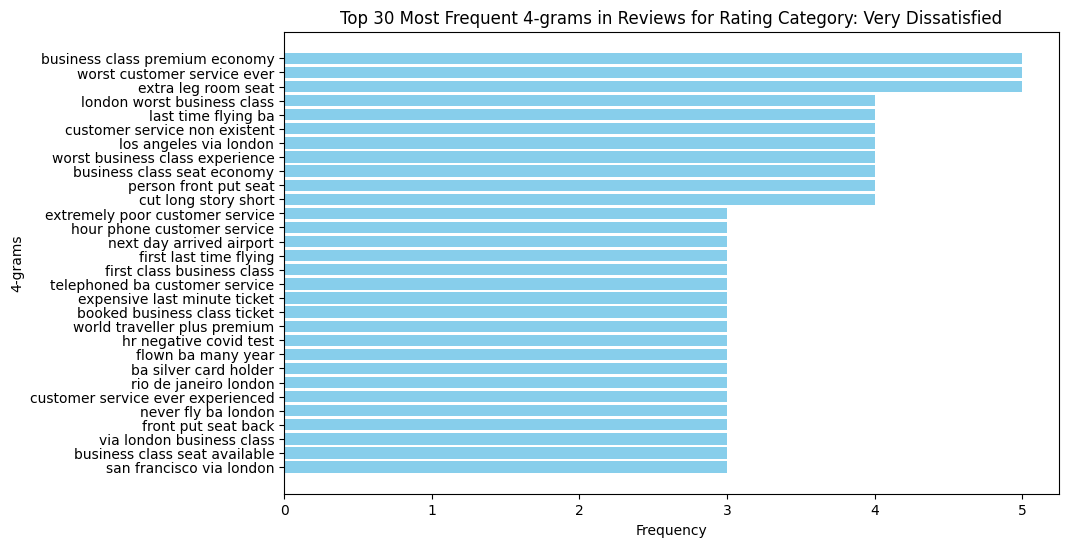

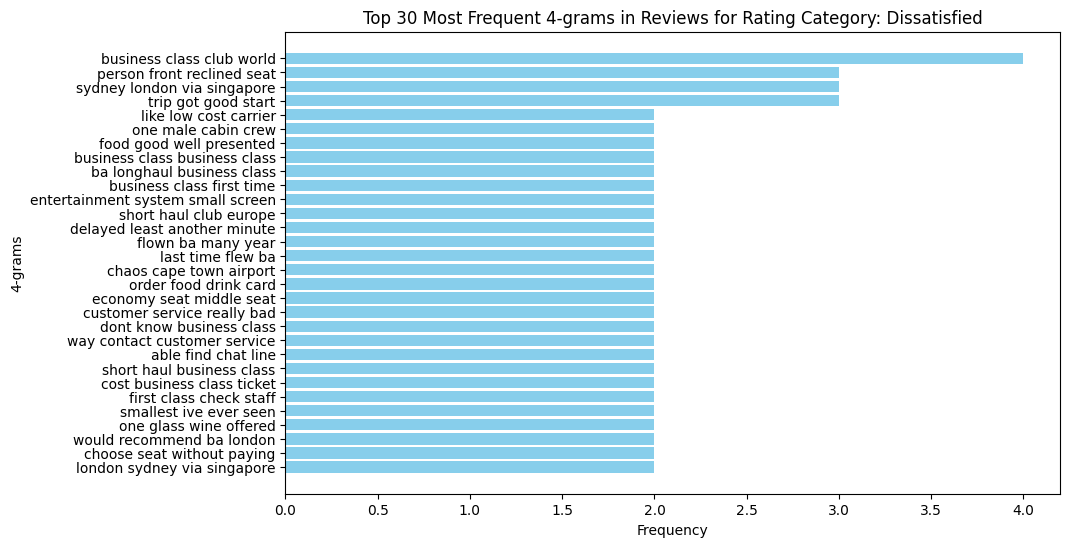

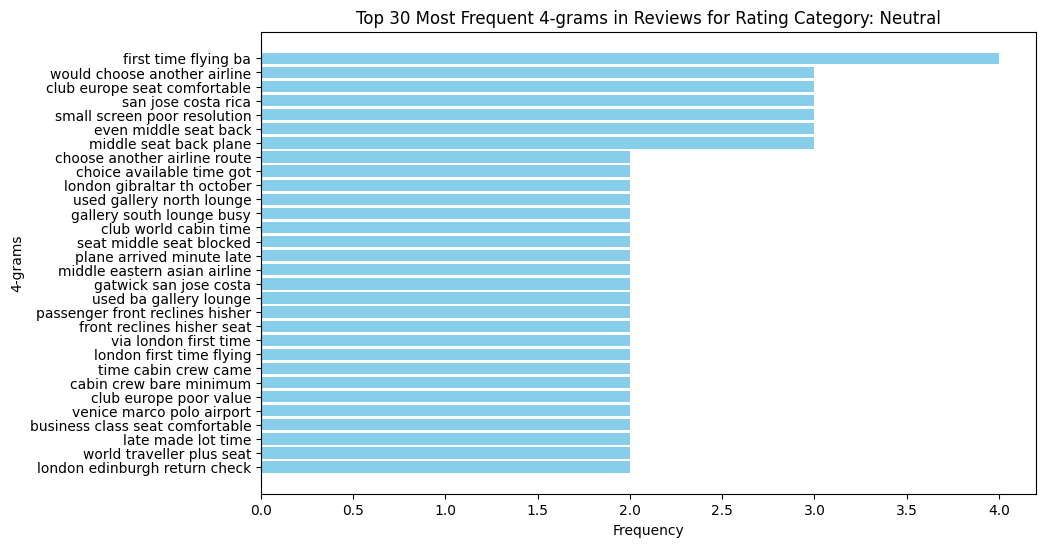

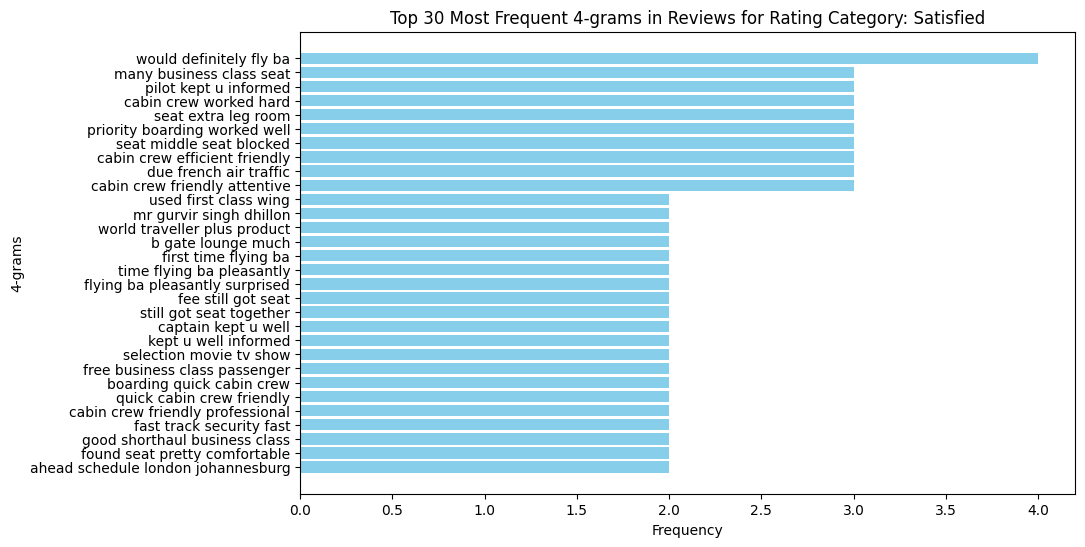

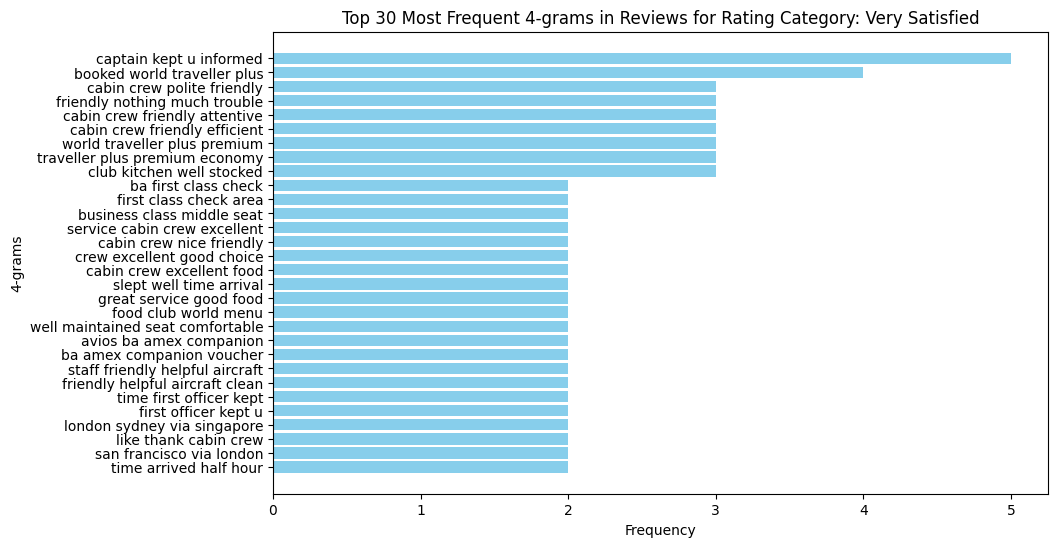

In [69]:

# Step 3: Function to analyze most frequent 4-grams for a specific rating category
def analyze_ngrams(category, n=4, top_n=30):
    # Filter reviews for a specific rating category
    category_reviews = cleaned_reviews_with_sentiment_score[cleaned_reviews_with_sentiment_score['Rating_Category'] == category]['Cleaned_Content'].dropna()
    
    # Clean and tokenize each review
    all_words = []
    for text in category_reviews:
        all_words.extend(clean_and_tokenize(text))
    
    # Generate n-grams (default to 4-grams)
    n_grams = list(ngrams(all_words, n))
    
    # Calculate frequency distribution
    fdist = FreqDist(n_grams)
    
    # Display the top n most common n-grams
    top_ngrams = fdist.most_common(top_n)
    
    # Plot the frequency distribution
    ngrams_str, freq = zip(*top_ngrams)  # Separate the n-grams and their frequencies
    ngrams_str = [' '.join(gram) for gram in ngrams_str]  # Convert tuple of words to strings

    # Plot the top n-grams
    plt.figure(figsize=(10, 6))
    plt.barh(ngrams_str, freq, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-grams')
    plt.title(f'Top {top_n} Most Frequent {n}-grams in Reviews for Rating Category: {category}')
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()

# Step 4: Analyze and plot 4-grams for each rating category
for category in ['Very Dissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very Satisfied']:
    analyze_ngrams(category, n=4, top_n=30)


### Key Observations from "Very Dissatisfied" Category:

1. **Premium Class Issues**: Frequent complaints about **business class** and **premium economy** services, including discomfort and unmet expectations.
   
2. **Customer Service**: Phrases like **"worst customer service ever"** and **"customer service non existent"** highlight major dissatisfaction with how issues were handled.

3. **Seat and Comfort**: Complaints about **seat availability**, **legroom**, and overall discomfort in seating, even in premium classes.

4. **High Costs**: Frustration over **expensive tickets** without corresponding service quality, especially in business class.

5. **Route-Specific Complaints**: Issues on long-haul routes like **Los Angeles**, **Rio de Janeiro**, and **San Francisco** via London.

6. **COVID-19 Concerns**: Complaints about handling of **COVID-19 policies**, such as negative test requirements.

7. **Frequent Flyers**: Even **loyal customers** (e.g., BA Silver cardholders) expressed dissatisfaction.

### Inferences:

- **Focus on Premium Classes**: Improve business class offerings to meet customer expectations.
- **Enhance Customer Service**: Address critical gaps in customer service response and issue resolution.
- **Improve Comfort**: Ensure better seating comfort, especially for premium-paying passengers.
- **Align Pricing with Service**: Ensure service quality matches high ticket prices.


### Key Observations from "Dissatisfied" Category:

1. **Business Class Issues**: Phrases like **"business class club world"**, **"business class first time"**, and **"short haul business class"** highlight dissatisfaction with business class services, both on short-haul and long-haul flights.

2. **Seat Comfort and Reclining**: Mentions of **"person front reclined seat"** and **"economy seat middle seat"** suggest issues with seat comfort and space, both in business and economy class.

3. **Customer Service**: Complaints such as **"customer service really bad"**, **"way contact customer service"**, and **"able find that line"** indicate ongoing frustrations with customer service access and quality.

4. **Food and Beverages**: Phrases like **"food well presented"** and **"one glass wine offered"** suggest mixed reviews on food service, with some dissatisfaction about quantity or quality.

5. **Delays and Airport Chaos**: Mentions of **"delayed least another minute"** and **"chaos cape town airport"** indicate frequent complaints about delays and operational inefficiencies.

6. **Premium Feel**: Mentions like **"like low cost carrier"** indicate that some passengers felt the service didn't meet the premium standards they expected, particularly in business class.

### Inferences:

- **Business Class Improvements**: Many complaints point to unmet expectations in business class services, with a focus on comfort and value for money.
- **Customer Service Issues**: Ongoing problems with accessing or interacting with customer service need urgent attention.
- **Seat Comfort**: Both business and economy class passengers express dissatisfaction with seat comfort, particularly with reclining seats and space in the cabin.
- **Operational Delays**: Delays and chaotic airport experiences contribute to dissatisfaction and need to be addressed for smoother operations.


### Key Observations from "Neutral" Category:

1. **First Time Flyers**: Phrases like **"first time flying ba"** and **"london first time flying"** suggest that many reviews come from first-time British Airways passengers, reflecting mixed experiences.

2. **Comparisons with Other Airlines**: The phrase **"would choose another airline"** indicates that some passengers may have felt indifferent about their experience and would consider other airlines in the future.

3. **Seating Comfort**: Mentions such as **"club europe seat comfortable"** and **"business class seat comfortable"** indicate that while seat comfort was noted, it did not leave a strong positive or negative impression.

4. **In-Flight Entertainment**: The phrase **"small screen poor resolution"** reflects dissatisfaction with the quality of inflight entertainment systems.

5. **Lounges and Airports**: Terms like **"used ba gallery lounge"**, **"gallery south lounge busy"**, and **"san jose costa rica"** suggest that the lounge and airport experience were common discussion points, with mixed feedback.

6. **Flight Timeliness**: Mentions like **"plane arrived minute late"** and **"middle eastern asian airline"** point to neutral feedback on flight timeliness and service comparisons with other airlines.

### Inferences:

- **Mixed First Impressions**: Many first-time flyers provided neutral feedback, indicating that their experience wasn’t impactful enough to be either strongly positive or negative.
- **Consideration of Other Airlines**: Some passengers seem open to exploring other airline options, suggesting that the experience with British Airways did not stand out significantly.
- **Comfort and Entertainment**: While some passengers found the seats comfortable, the inflight entertainment received criticism, highlighting an area for potential improvement.
- **Operational Experience**: Lounge and airport experiences, as well as flight punctuality, were neither overwhelmingly positive nor negative, reflecting an overall average service level.


### Key Observations from "Satisfied" Category:

1. **Willingness to Fly Again**: The phrase **"would definitely fly ba"** indicates that many passengers had a positive enough experience to consider flying with British Airways again.

2. **Business Class Satisfaction**: Mentions like **"many business class seat"** and **"good shorthaul business class"** suggest that business class passengers were generally satisfied with the seating and service.

3. **Cabin Crew Performance**: Phrases such as **"cabin crew worked hard"**, **"cabin crew friendly attentive"**, and **"cabin crew efficient friendly"** reflect positive feedback regarding the professionalism and attentiveness of the flight crew.

4. **Communication from Pilots**: The phrase **"pilot kept u informed"** shows that passengers appreciated updates from the cockpit, which contributed to a better overall experience.

5. **Comfort and Boarding**: Terms like **"seat extra leg room"**, **"priority boarding worked well"**, and **"found seat pretty comfortable"** indicate that comfort and the boarding process were well-received.

6. **Timeliness and Lounge Experience**: Mentions such as **"ahead schedule london johannesburg"** and **"b gate lounge much"** show satisfaction with the punctuality of flights and the lounge services.

### Inferences:

- **Positive Business Class Experience**: Many business class passengers had positive experiences, particularly with seating and service.
- **Strong Crew Performance**: The cabin crew’s professionalism and friendliness played a key role in passengers' satisfaction.
- **Good Communication and Comfort**: Regular updates from the pilot and comfortable seating contributed to a smoother and more enjoyable experience.
- **Efficient Boarding and Timeliness**: Passengers appreciated efficient boarding processes and punctual flights.


Rating_Category
Very Dissatisfied    35.549133
Satisfied            18.234367
Dissatisfied         17.840252
Very Satisfied       17.078297
Neutral              11.297951
Name: count, dtype: float64


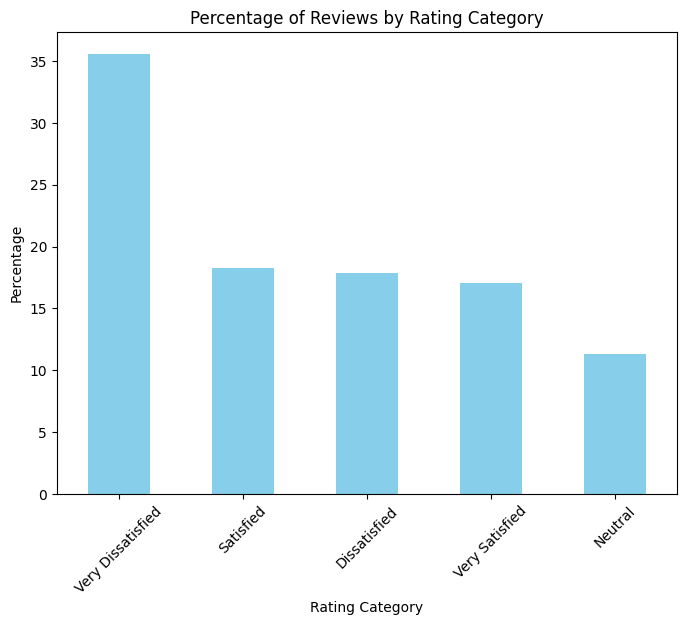

In [70]:
# Percentage of Reviews by Rating Category
# Step 1: Calculate the count of reviews in each category
category_counts = cleaned_reviews_with_sentiment_score['Rating_Category'].value_counts()

# Step 2: Calculate the percentage of each category
category_percentages = (category_counts / len(cleaned_reviews_with_sentiment_score)) * 100

# Step 3: Display the percentages for each category
print(category_percentages)


# Plot the percentage distribution
plt.figure(figsize=(8, 6))
category_percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Reviews by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()


Seat Type
Economy Class      58.169291
Business Class     28.297244
Premium Economy     9.399606
First Class         4.035433
Unknown             0.098425
Name: count, dtype: float64


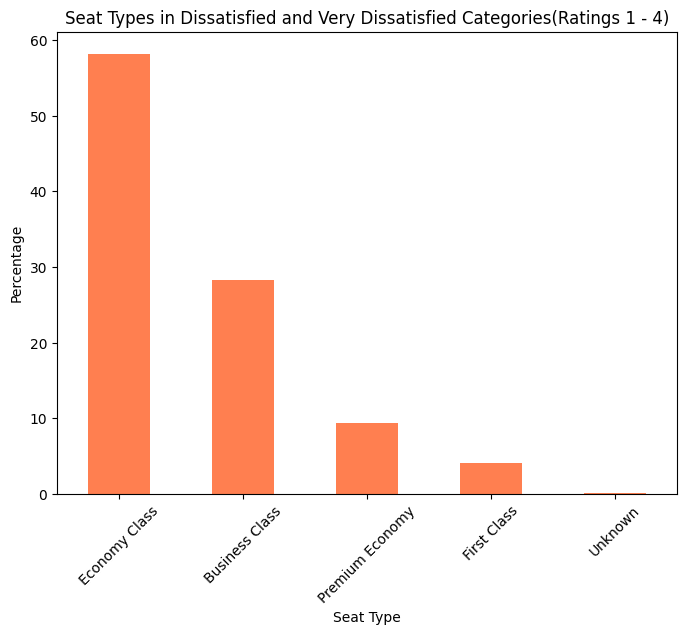

In [71]:
# Seat Types in Dissatisfied and Very Dissatisfied Categories(Ratings 1 - 4)
# Step 1: Filter data for 'Dissatisfied' and 'Very Dissatisfied' categories
dissatisfied_df = cleaned_reviews_with_sentiment_score[cleaned_reviews_with_sentiment_score['Rating_Category'].isin(['Dissatisfied', 'Very Dissatisfied'])]

# Step 2: Calculate the count of each seat type in these categories
seat_type_counts = dissatisfied_df['Seat Type'].value_counts()

# Step 3: Calculate the percentage of each seat type in these categories
seat_type_percentages = (seat_type_counts / len(dissatisfied_df)) * 100

# Step 4: Display the results
print(seat_type_percentages)

# Optional: Visualize the distribution with a bar plot
import matplotlib.pyplot as plt

# Plot the seat type distribution for Dissatisfied and Very Dissatisfied categories
plt.figure(figsize=(8, 6))
seat_type_percentages.plot(kind='bar', color='coral')
plt.title('Seat Types in Dissatisfied and Very Dissatisfied Categories(Ratings 1 - 4)')
plt.xlabel('Seat Type')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()


### Observations:

#### **Percentage of Reviews by Rating Category**:
- **Very Dissatisfied**: Around 35% of reviews fall into this category, indicating a significant level of dissatisfaction.
- **Even Distribution**: The **Satisfied**, **Dissatisfied**, and **Very Satisfied** categories each contribute about 15-20%.
- **Neutral**: The smallest category, indicating fewer passengers felt indifferent about their experience.

#### **Seat Types in Dissatisfied and Very Dissatisfied Categories**:
- **Economy Class**: Over 50% of dissatisfied reviews come from **Economy Class**, making it the biggest contributor to dissatisfaction.
- **Business Class**: Around 30% of negative reviews are from **Business Class**, suggesting unmet expectations in premium service.
- **Premium Economy and First Class**: These categories contribute smaller proportions, with **Premium Economy** at 10% and **First Class** even less.

### Inferences:
- **Economy Class Focus**: **Economy** is the largest source of dissatisfaction and should be a key area for improvement.
- **Business Class Review**: Significant dissatisfaction in **Business Class** indicates the need to better meet premium expectations.
- **Polarized Reviews**: A high number of **Very Dissatisfied** reviews suggests inconsistent service, leading to extreme customer experiences.


<Figure size 1000x600 with 0 Axes>

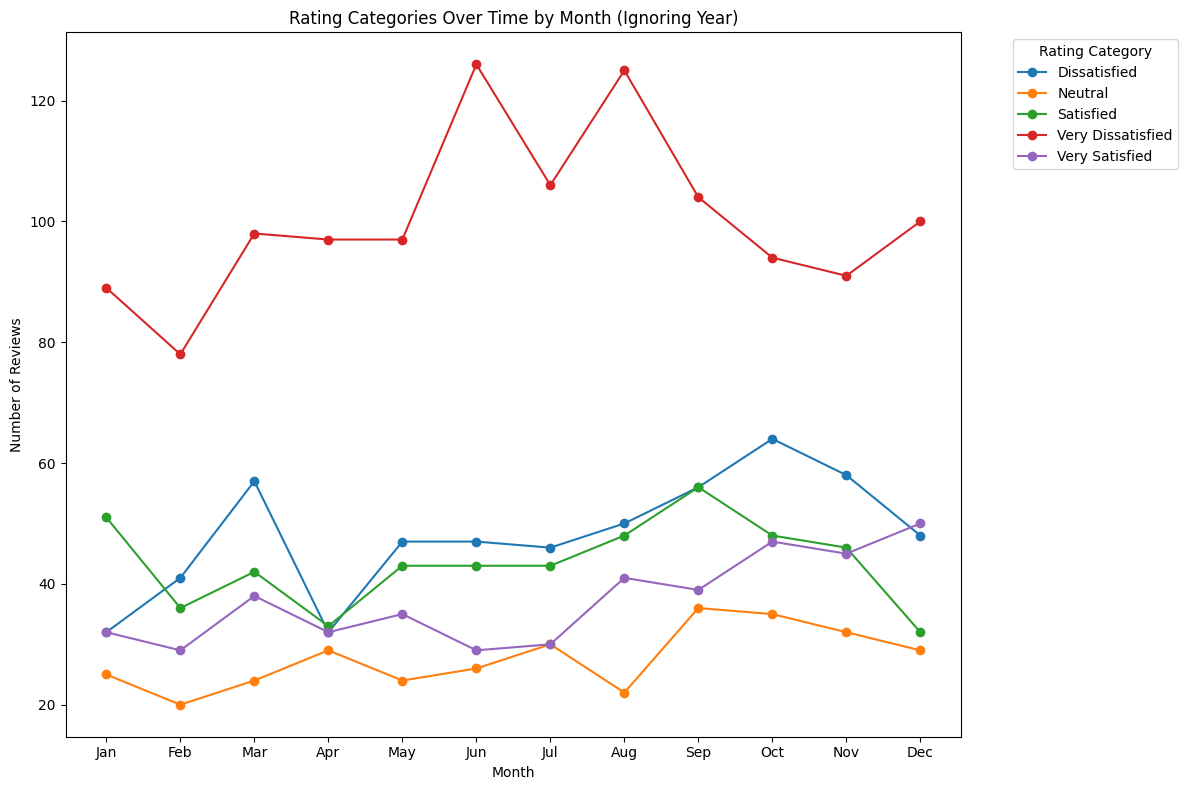

In [72]:
# Rating Categories Over Time by Month

# Step 1: Convert 'Date Flown' to a datetime format if it's not already
cleaned_reviews_with_sentiment_score['Date Flown'] = pd.to_datetime(cleaned_reviews_with_sentiment_score['Date Flown'], errors='coerce')

# Step 2: Extract only the month from 'Date Flown' (ignoring the year)
cleaned_reviews_with_sentiment_score['Month'] = cleaned_reviews_with_sentiment_score['Date Flown'].dt.month

# Step 3: Group the data by 'Rating_Category' and 'Month' and count the occurrences
ratings_by_month = cleaned_reviews_with_sentiment_score.groupby(['Month', 'Rating_Category']).size().unstack(fill_value=0)

# Step 4: Plot the data to compare rating categories by month (ignoring year)
plt.figure(figsize=(10, 6))
ratings_by_month.plot(kind='line', marker='o', figsize=(12, 8))

plt.title('Rating Categories Over Time by Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Rating Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Observations:

1. **Very Dissatisfied Dominates**: The **Very Dissatisfied** category consistently has the highest reviews, peaking in **July** and **October**.
2. **Dissatisfied Increases Mid-Year**: **Dissatisfied** reviews rise from **May** to **September**, with a peak in **October**.
3. **Steady Satisfied and Very Satisfied**: Both **Satisfied** and **Very Satisfied** remain relatively stable, with slight increases in **March**, **September**, and **November**.
4. **Low Neutral Reviews**: The **Neutral** category has the fewest reviews throughout the year.

### Inferences:

1. **Operational Issues in Peak Months**: Spikes in **July** and **October** suggest issues during peak travel periods.
2. **Consistent Dissatisfaction**: High numbers of **Very Dissatisfied** reviews year-round indicate ongoing customer service problems.
3. **Moderate Satisfaction**: The relatively steady **Satisfied** reviews show some level of contentment, but the majority lean towards dissatisfaction.

### Conclusion:
British Airways faces significant customer dissatisfaction, particularly during high-demand travel months, indicating a need for operational and service improvements.


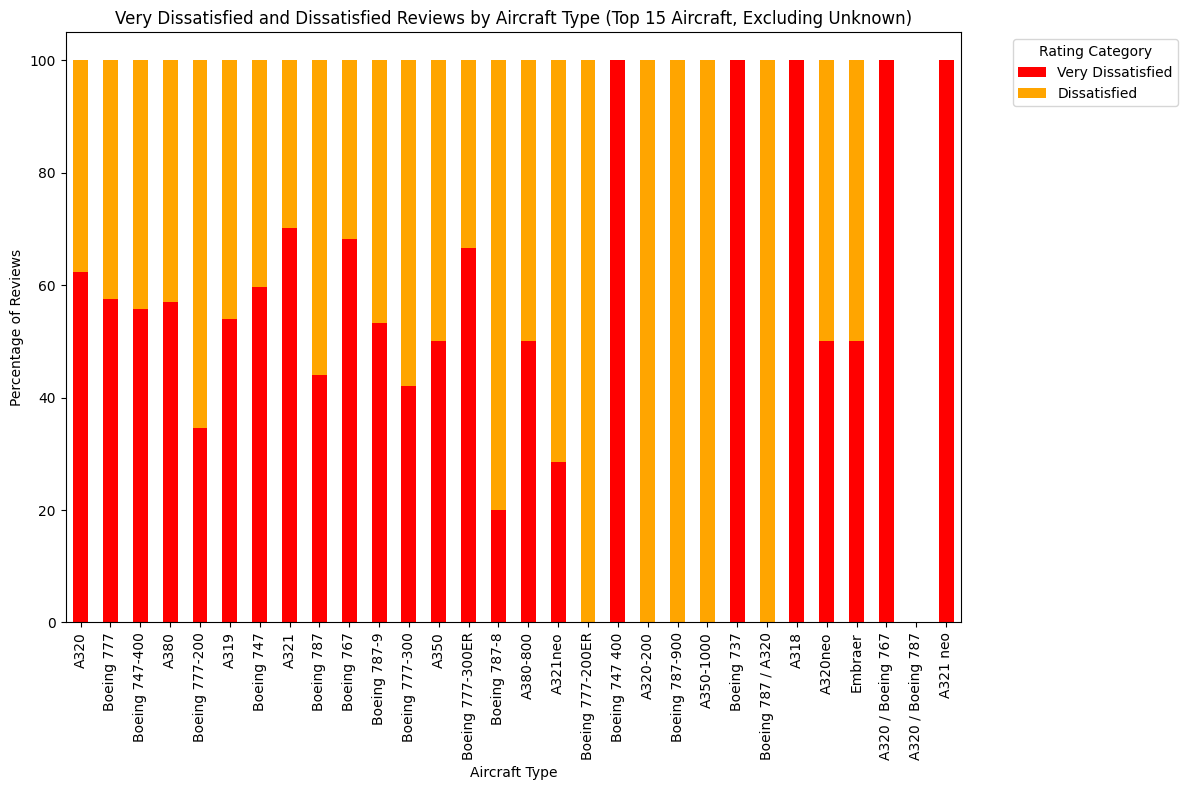

In [73]:
# Very Dissatisfied and Dissatisfied Reviews by Aircraft Type (Top 15 Aircraft)

# Step 1: Filter out rows where 'Aircraft' is 'Unknown'
filtered_df = cleaned_reviews_with_sentiment_score[cleaned_reviews_with_sentiment_score['Aircraft'] != 'Unknown']

# Step 2: Group data by 'Aircraft' and 'Rating_Category', then count the occurrences
ratings_by_aircraft = filtered_df.groupby(['Aircraft', 'Rating_Category']).size().unstack(fill_value=0)

# Step 3: Filter to get the top 30 aircraft by total number of reviews
top_30_aircraft = ratings_by_aircraft.sum(axis=1).nlargest(30).index
ratings_by_aircraft_top_30 = ratings_by_aircraft.loc[top_30_aircraft]

# Step 4: Select only the 'Very Dissatisfied' and 'Dissatisfied' categories
ratings_by_aircraft_top_30 = ratings_by_aircraft_top_30[['Very Dissatisfied', 'Dissatisfied']]

# Step 5: Calculate the percentage of these two categories for each aircraft type in the top 15
ratings_by_aircraft_percentage_top_30 = ratings_by_aircraft_top_30.div(ratings_by_aircraft_top_30.sum(axis=1), axis=0) * 100

# Step 6: Plot the data to compare Very Dissatisfied and Dissatisfied categories by aircraft type (Top 15 only)
ratings_by_aircraft_percentage_top_30.plot(kind='bar', stacked=True, figsize=(12, 8), color=['red', 'orange'])

plt.title('Very Dissatisfied and Dissatisfied Reviews by Aircraft Type (Top 15 Aircraft, Excluding Unknown)')
plt.xlabel('Aircraft Type')
plt.ylabel('Percentage of Reviews')
plt.legend(title='Rating Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Observations:
- **Boeing 777-9** and **Boeing 787-9** have the highest percentage of **Very Dissatisfied** reviews.
- **A321** and **Boeing 747-400** have a more balanced split between **Dissatisfied** and **Very Dissatisfied** categories.
- **A320** shows a consistent level of dissatisfaction but does not have the extremes of very dissatisfied seen in other aircraft types.
  
### Inferences:
- Certain aircraft models like **Boeing 777-9** and **Boeing 787-9** may require attention to improve customer satisfaction, as they consistently have higher dissatisfaction levels.
- **A320** and **A321** show moderate dissatisfaction but not as extreme as other models, indicating potential areas of improvement without a complete overhaul.

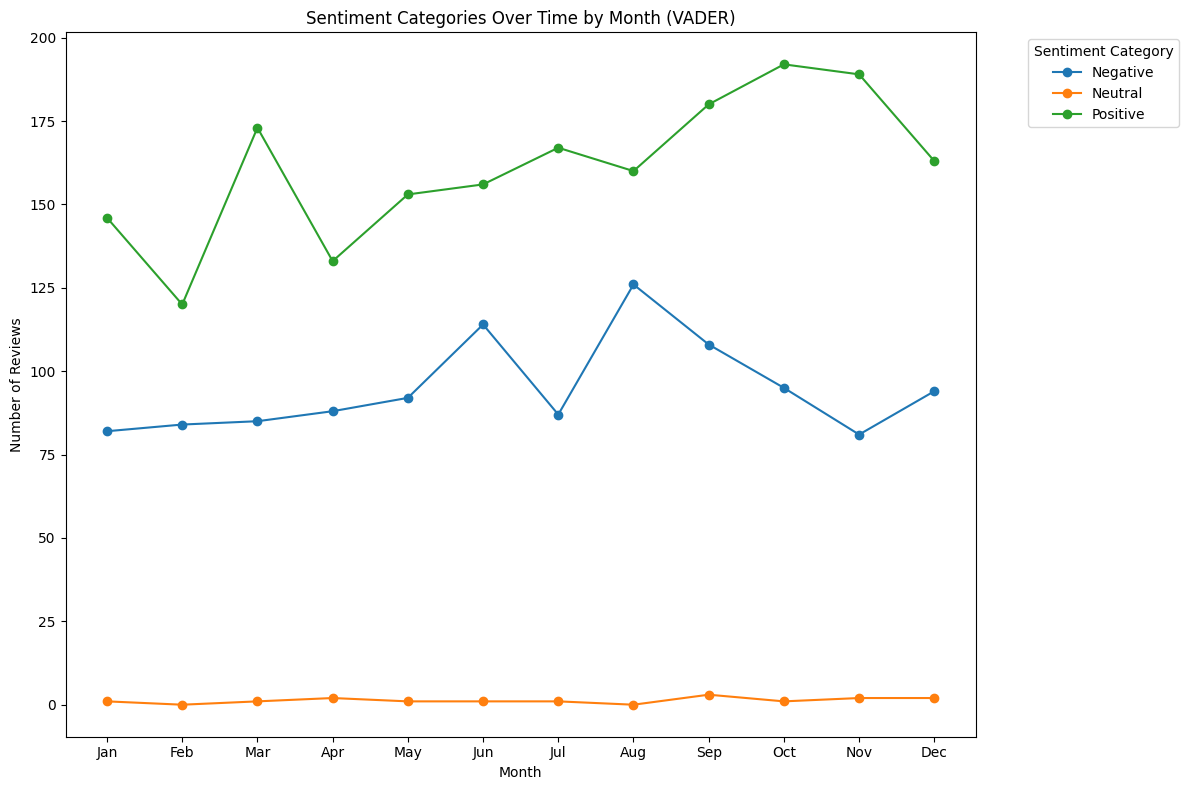

In [74]:
# Sentiment Categories Over Time by Month

# Step 1: Convert 'Date Flown' to a datetime format if it's not already
cleaned_reviews_with_sentiment_score['Date Flown'] = pd.to_datetime(cleaned_reviews_with_sentiment_score['Date Flown'], errors='coerce')

# Step 2: Extract the month from 'Date Flown' (ignoring the year)
cleaned_reviews_with_sentiment_score['Month'] = cleaned_reviews_with_sentiment_score['Date Flown'].dt.month

# Step 3: Group the data by 'Month' and 'Sentiment_Category_VADER', then count the occurrences
sentiment_by_month = cleaned_reviews_with_sentiment_score.groupby(['Month', 'Sentiment_Category_VADER']).size().unstack(fill_value=0)

# Step 4: Plot the data to compare sentiment categories over months
sentiment_by_month.plot(kind='line', marker='o', figsize=(12, 8))

plt.title('Sentiment Categories Over Time by Month (VADER)')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Sentiment Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Observations:

1. **Positive Sentiment Dominates**: Positive reviews are consistently higher, peaking in **June** and **October**, with dips in **May** and **July**.
2. **Negative Sentiment Trends**: Negative reviews spike in **June** and decline steadily from **September** to **December**.
3. **Neutral Sentiment is Minimal**: Neutral reviews are consistently low throughout the year.
4. **Mid-Year Fluctuations**: Both positive and negative sentiments fluctuate around **June** and **July**, indicating mixed experiences during that period.

### Inferences:

1. **Majority Positive Experience**: Most reviews are positive, though there are notable fluctuations during peak travel months.
2. **Operational Improvements**: The decline in negative reviews toward the end of the year suggests improvements in service.
3. **Mixed Experiences Mid-Year**: Peaks in both positive and negative reviews during **June** suggest operational challenges or seasonal factors impacting customer satisfaction.



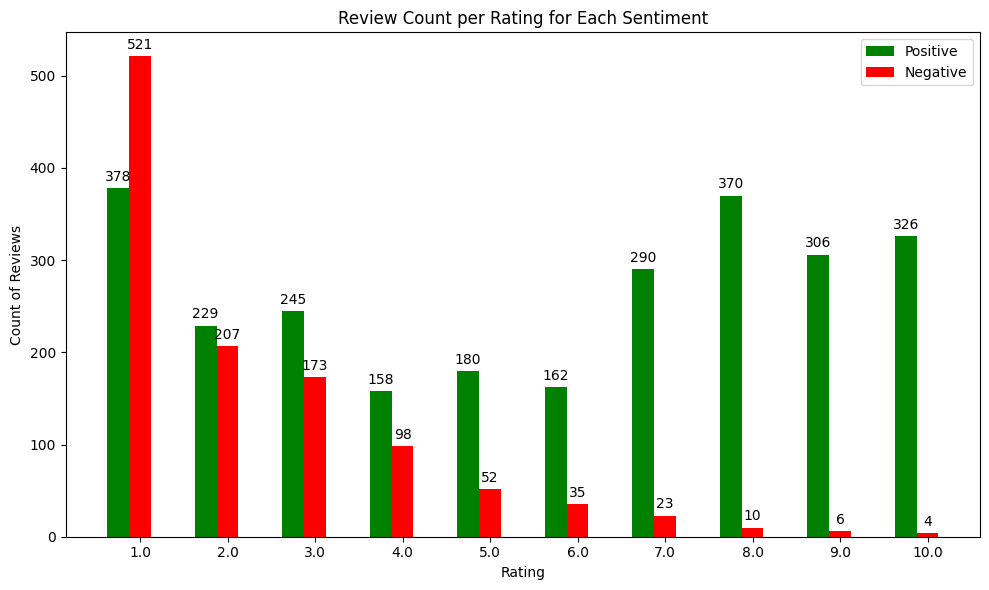

In [75]:
# Review Count per Rating for Each Sentiment

# Step 1: Group by Rating and Sentiment Category and get the count of reviews
rating_sentiment_counts = cleaned_reviews_with_sentiment_score.groupby(['Rating', 'Sentiment_Category_TextBlob']).size().unstack(fill_value=0)

# Step 2: Plot a grouped bar chart for each rating with counts for each sentiment (Positive, Negative, Neutral)
ratings = rating_sentiment_counts.index  # Ratings (1, 2, 3, 4, 5, etc.)
positive_counts = rating_sentiment_counts['Positive']
negative_counts = rating_sentiment_counts['Negative']
#neutral_counts = rating_sentiment_counts['Neutral']

# Setting up the bar chart
bar_width = 0.25  # Width of each bar
x = np.arange(len(ratings))  # the label locations

# Creating the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars for each sentiment category
rects1 = ax.bar(x - bar_width, positive_counts, bar_width, label='Positive', color='green')
#rects2 = ax.bar(x, neutral_counts, bar_width, label='Neutral', color='orange')
rects2 = ax.bar(x, negative_counts, bar_width, label='Negative', color='red')

# Adding labels, title and custom x-axis tick labels
ax.set_xlabel('Rating')
ax.set_ylabel('Count of Reviews')
ax.set_title('Review Count per Rating for Each Sentiment')
ax.set_xticks(x)
ax.set_xticklabels(ratings)
ax.legend()

# Add counts on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
#add_labels(rects2)
add_labels(rects2)

# Display the plot
plt.tight_layout()
plt.show()
